# Marketing Campaign

In [53]:
from IPython.display import Image

# Background Information

Personalized customer emails based off marketing analytics is a winning formula for many digital companies, and this is exactly the initiative that the leadership team at DVD Rental Co has decided to tackle!

We have been asked to support the customer analytics team at DVD Rental Co who have been tasked with generating the necessary data points required to populate specific parts of this first-ever customer email campaign.

## Email Template

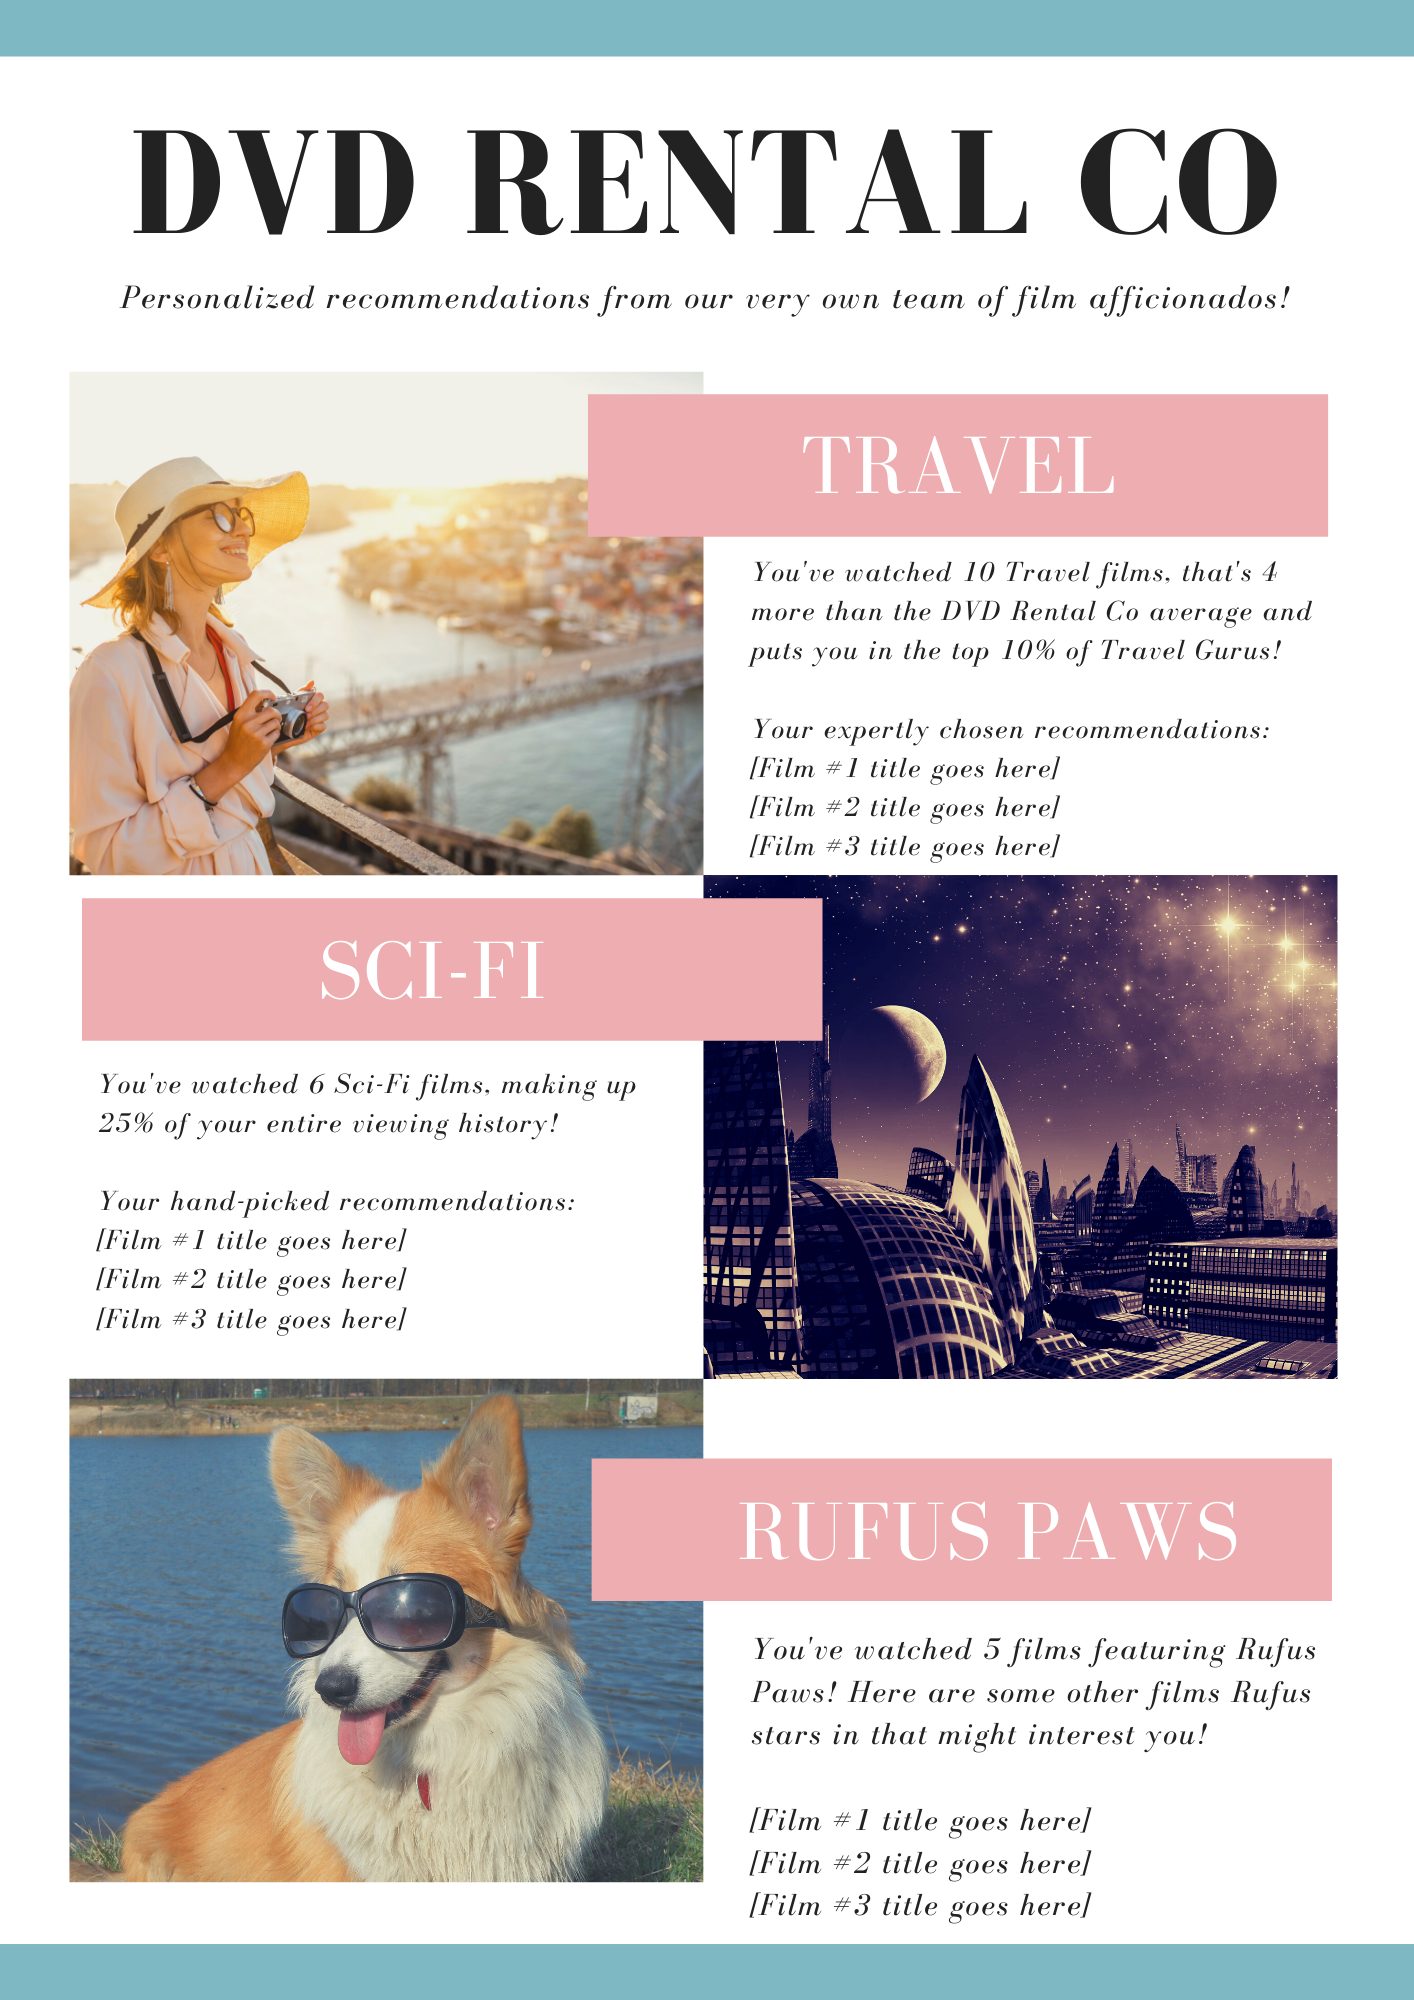

In [54]:
Image(filename="./resources/email-template.png", width=550)

## Requirements

1. ```Top 2 Categories```
   - For each customer, we need to identify the top 2 categories based off their past rental history. These top categories will drive marketing creative images as seen in the travel and sci-fi examples in the draft email.
***
2. ```Category Film Recommendations```
   - The marketing team has also requested for the 3 most popular films for each customer’s top 2 categories.
   - we cannot recommend a film which the customer has already viewed.
   - If there are less than 3 films available - marketing is happy to show at least 1 film.
   - Any customer which do not have any film recommendations for either category must be flagged out so the marketing team can exclude from the email campaign this is of high importance!
***
3. ```Individual Customer Insights```
   - The number of films watched by each customer in their top 2 categories is required as well as some specific insights.
     
   - For the 1st category, the marketing requires the following insights (requirement 3):
        - How many total films have they watched in their top category?
        - How many more films has the customer watched compared to the average DVD Rental Co customer?
        - How does the customer rank in terms of the top X% compared to all other customers in this film category?

     
   - For the second ranking category (requirement 4):
        - How many total films has the customer watched in this category?
        - What proportion of each customer’s total films watched does this count make?
***
4. ```Favorite Actor Recommendations```
    - Along with the top 2 categories, marketing has also requested top actor film recommendations where up to 3 more films are included in the recommendations list as well as the count of films by the top actor.

    - We have been given guidance by marketing to choose the actors in alphabetical order should there be any ties
    - in addition any films that have already been recommended in the top 2 categories must not be included as actor recommendations.
    - If the customer doesn’t have at least 1 film recommendation - they also need to be flagged with a separate actor exclusion flag.

# Dataset Overview

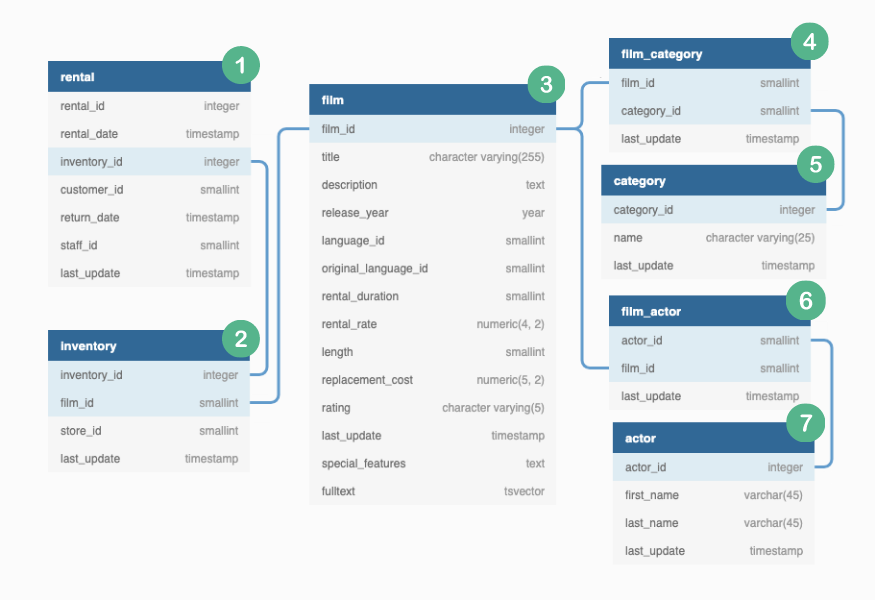

In [55]:
Image(filename="./resources/Marketing Campaign ERD.png")

# Analysis

**CUSTOMER INSIGHTS**
***

```sql
-- Did customers rent the same film multiple times? If so, is it logical to add it to the total count or not?
WITH cte_watched_multiple_times AS ( 
  SELECT
    t1.customer_id,
    COUNT(*) AS total_rentals,
    COUNT(DISTINCT film_id) AS unique_films_watched
  FROM dvd_rentals.rental AS t1
  INNER JOIN dvd_rentals.inventory AS t2 ON t1.inventory_id = t2.inventory_id
  GROUP BY t1.customer_id
)
SELECT *
FROM cte_watched_multiple_times
ORDER BY customer_id
```

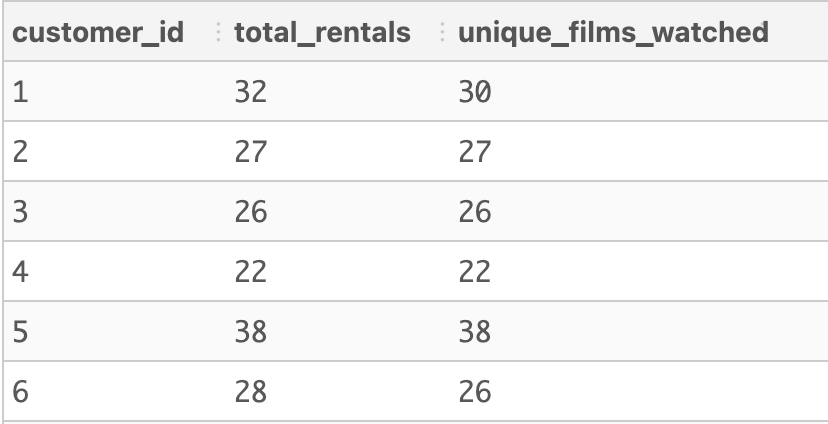

In [84]:
Image(filename="./resources/ma-1.png", width=600)

From the above output we can clearly see that some customers have indeed watched the same film multiple times. If they are renting/ watching the same film multiple time it indicates they like this film/ category, it adds more weight to a certain category. I have taken the decision to take these duplicates into consideration also by using ```COUNT(*)``` instead for using ```COUNT(DISTINCT )```. In reality, this is something that should be discussed with the business team prior to analysis. i.e. What defines someone whatching a film?

Before we create a base dataset, lets inspect the inventory table

```sql
SELECT *
FROM dvd_rentals.inventory
WHERE film_id = 1;
```

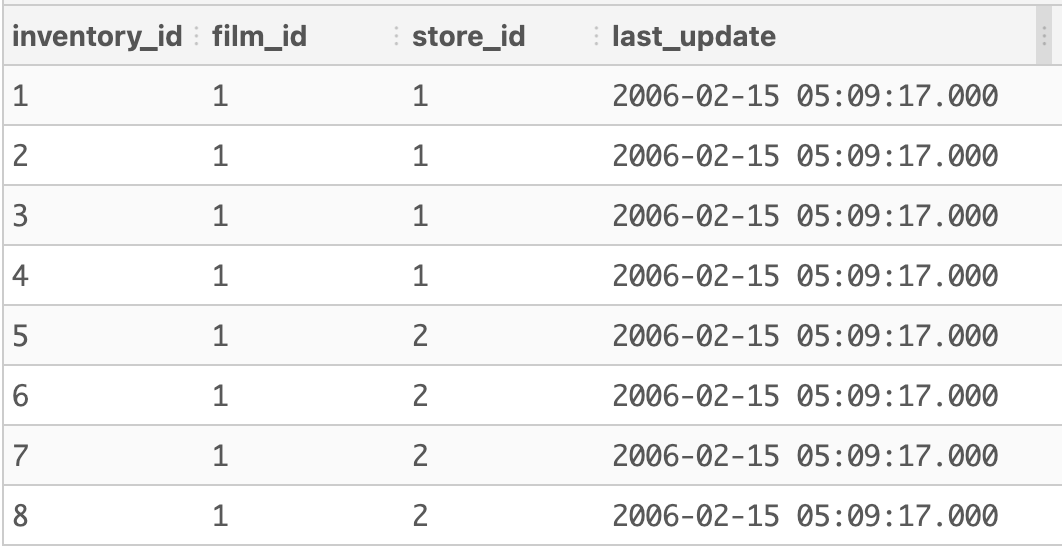

In [85]:
Image(filename="./resources/ma-2.png", width=500)

From the above output we can see that DVD Rental Co has 2 stores, each having multiple copies of the same film BUT across both stores the inventory_id is unique acting as the ```PRIMARY KEY``` for this table.

```sql
-- base dataset joining all relevant tables
WITH complete_joint_dataset AS (
    SELECT 
        t1.customer_id,
        t2.film_id,
        t3.title,
        t5.category_id,
        t5.name AS category_name,
        t1.rental_date -- helps us with sorting (acts as a recency metric)
   FROM dvd_rentals.rental AS t1
   INNER JOIN dvd_rentals.inventory AS t2 ON t2.inventory_id = t1.inventory_id
   INNER JOIN dvd_rentals.film t3 ON t3.film_id = t2.film_id
   INNER JOIN dvd_rentals.film_category t4 ON t4.film_id = t3.film_id
   INNER JOIN dvd_rentals.category t5 ON t5.category_id = t4.category_id
)
```

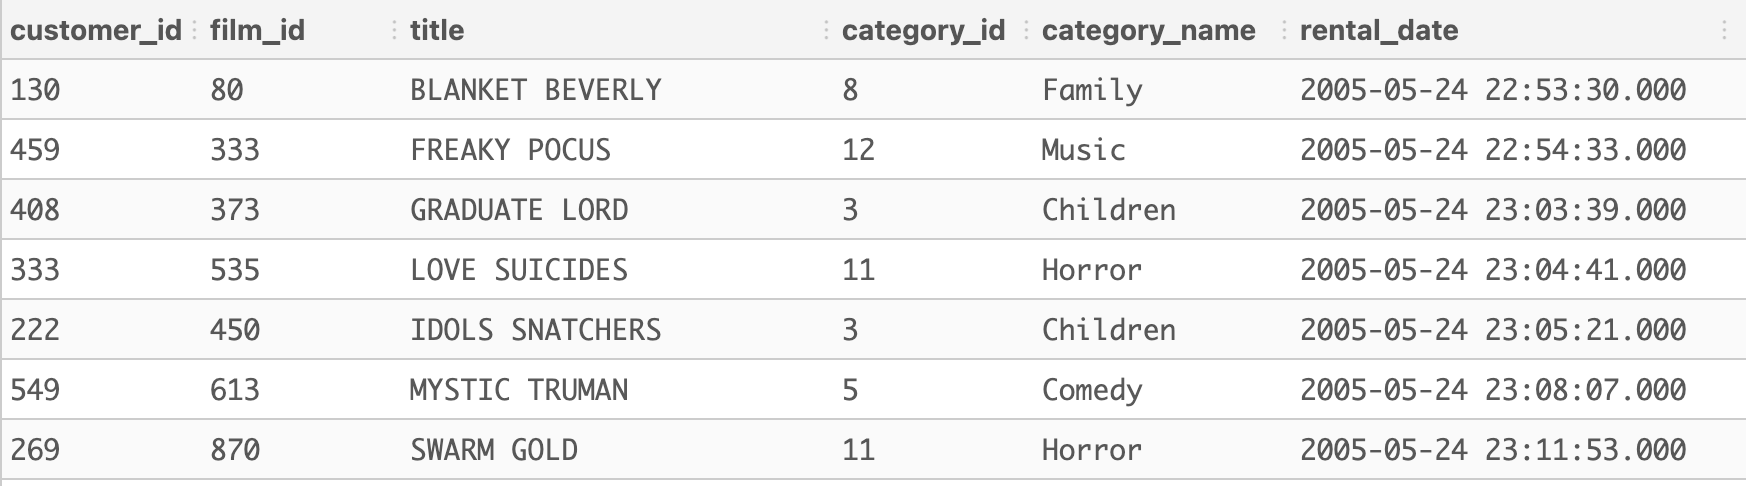

In [86]:
Image(filename='./resources/ma-3.png')

```sql
-- calculate customer rental counts for each category
WITH category_counts AS (
    SELECT 
        customer_id,
        category_name,
        count(*) AS rental_count,
        max(rental_date) AS latest_rental_date
   FROM complete_joint_dataset
   GROUP BY customer_id, category_name
)
```

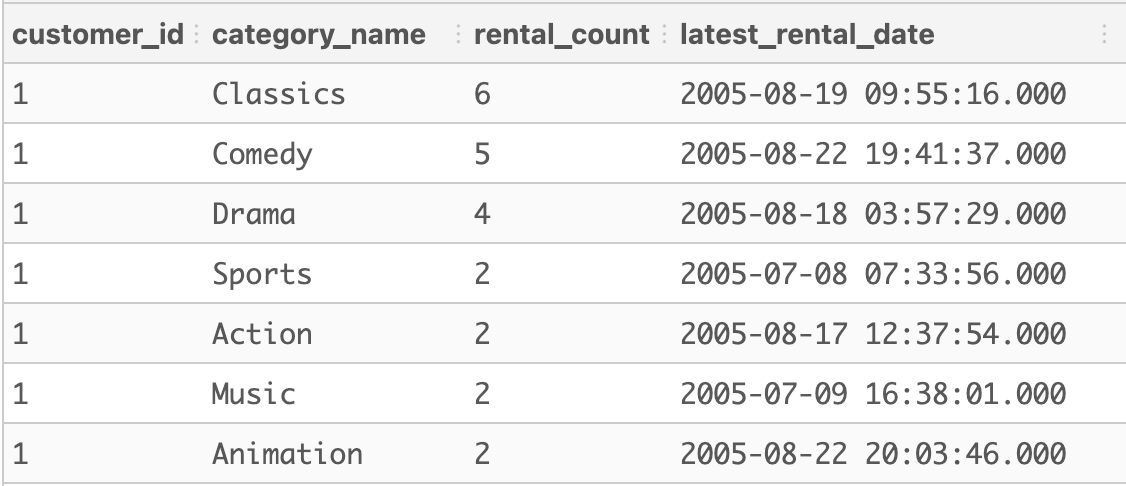

In [87]:
Image(filename='./resources/ma-4.png', width=700)

```sql
-- aggregate all customer total films watched
WITH total_counts AS (
    SELECT 
        customer_id,
        SUM(rental_count) AS total_count
   FROM category_counts
   GROUP BY customer_id
)
```

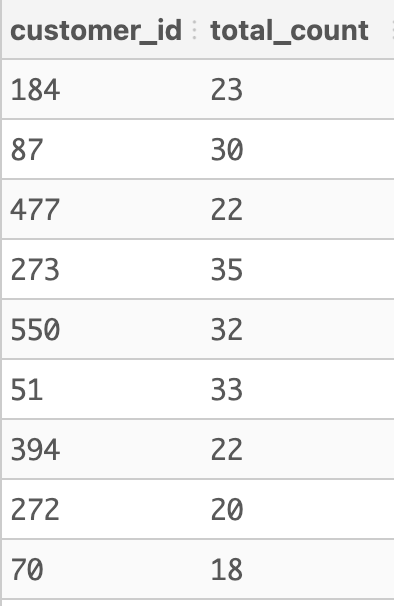

In [88]:
Image(filename='./resources/ma-5.png', width=300)

```sql
-- identify the top 2 categories for each customer
WITH top_categories AS (
    SELECT *
    FROM (
        SELECT 
            customer_id,
            category_name,
            rental_count,
            ROW_NUMBER() OVER(PARTITION BY customer_id
                               ORDER BY rental_count DESC, latest_rental_date DESC, category_name) AS category_rank
      FROM category_counts
    ) AS subquery
    WHERE category_rank <= 2
)
```

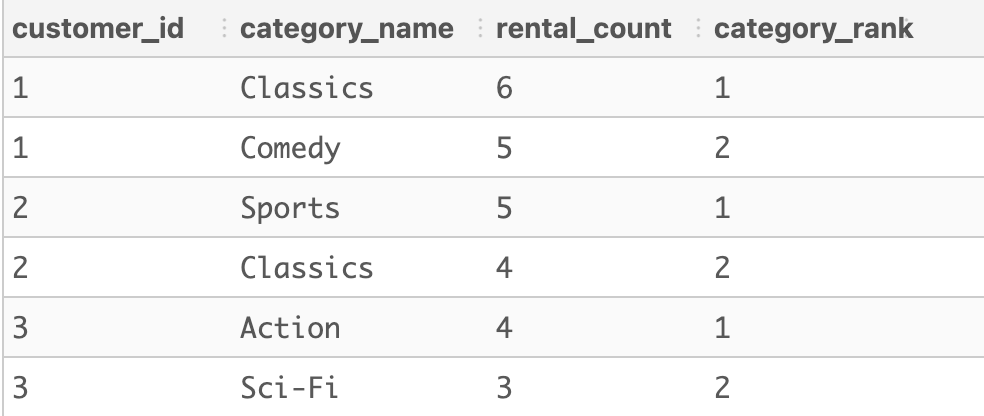

In [89]:
Image(filename='./resources/ma-6.png', width=600)

The reason for using for ```ROW_NUMBER()``` instead of RANK() OR DENSE_RANK() is that some customers have watched the same amount of films for different categories. ROW_NUMBER() solves this problem and allows us to extract the top two categories for each customer. Below is an example of a customer and their category wise counts. We observe that this customers' top two categories have the same number of films watched.

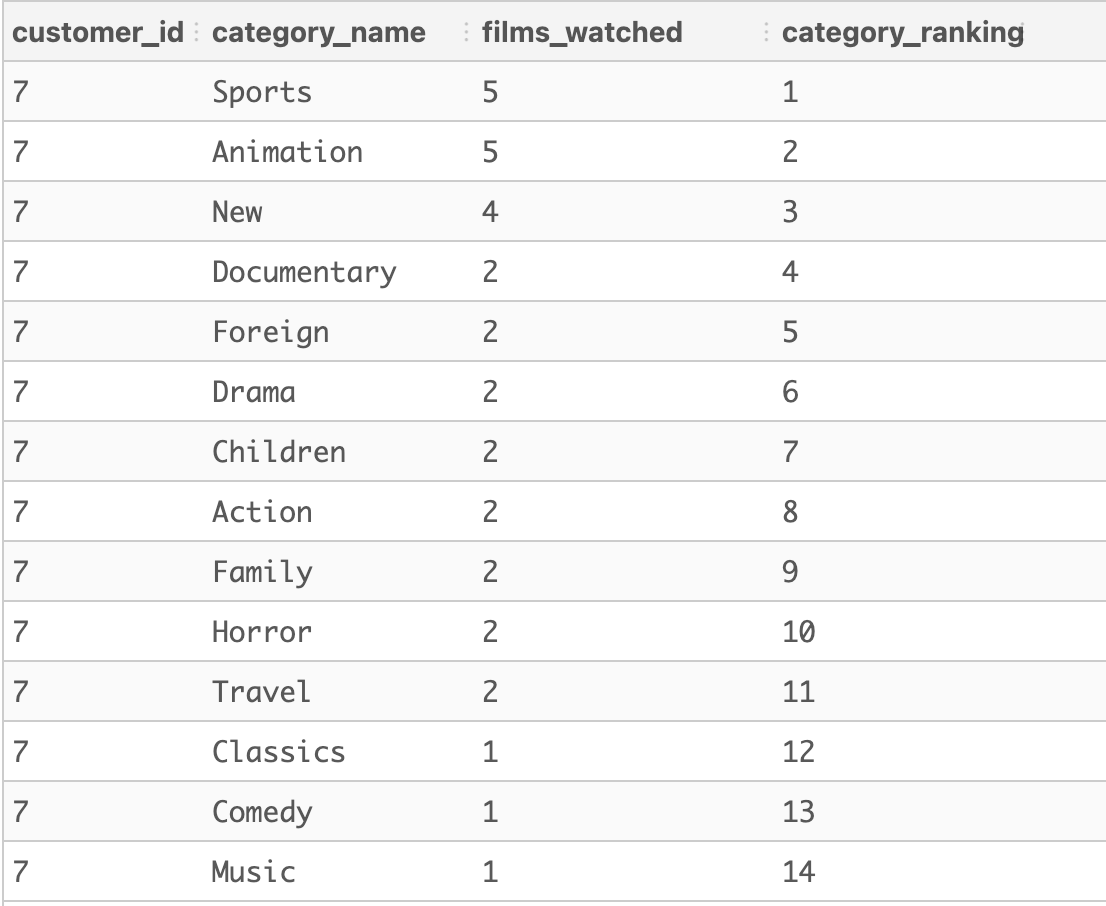

In [90]:
Image(filename="./resources/ma-7.png", width=500)

```sql
-- calculate each category’s aggregated average rental count
WITH average_category_count AS (
    SELECT 
        category_name,
        floor(avg(rental_count)) AS category_average -- using floor gives customers a bit of a feel-good boost that they watch more films
   FROM category_counts
   GROUP BY category_name
)
```

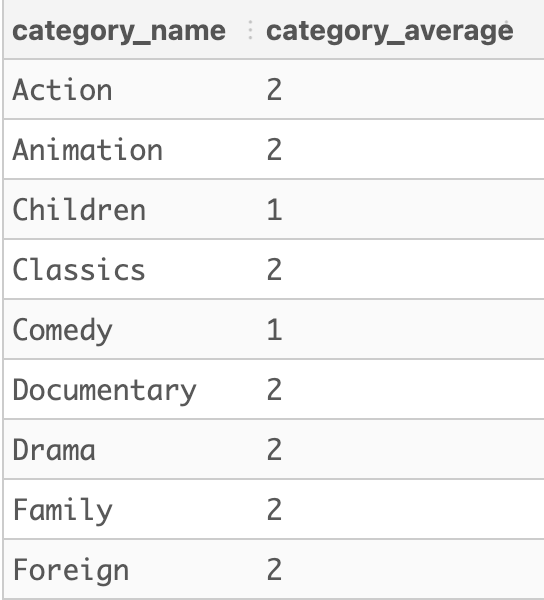

In [91]:
Image(filename="./resources/ma-8.png", width=300)

```sql
-- calculate the percentile metric for each customer’s top category film count
WITH top_category_percentile AS (
    SELECT 
        customer_id,
        category_name,
        rental_count,
        category_rank,
        CASE
            WHEN top_n = 0 THEN 1 -- We wouldn't want to tell the customer that they rank among the top 0%
            ELSE top_n
        END AS percentile
   FROM (
        SELECT 
            top_categories.customer_id,
            top_categories.category_name AS top_category_name,
            top_categories.rental_count,
            category_counts.category_name,
            top_categories.category_rank,
            CEILING(100* (1 - CUME_DIST() OVER(PARTITION BY category_counts.category_name
                                                ORDER BY category_counts.rental_count ASC))) AS top_n
          FROM category_counts
          LEFT JOIN top_categories ON (category_counts.customer_id = top_categories.customer_id)
          AND (category_counts.category_name = top_categories.category_name)
    ) AS subquery
   WHERE category_rank = 1
)
```

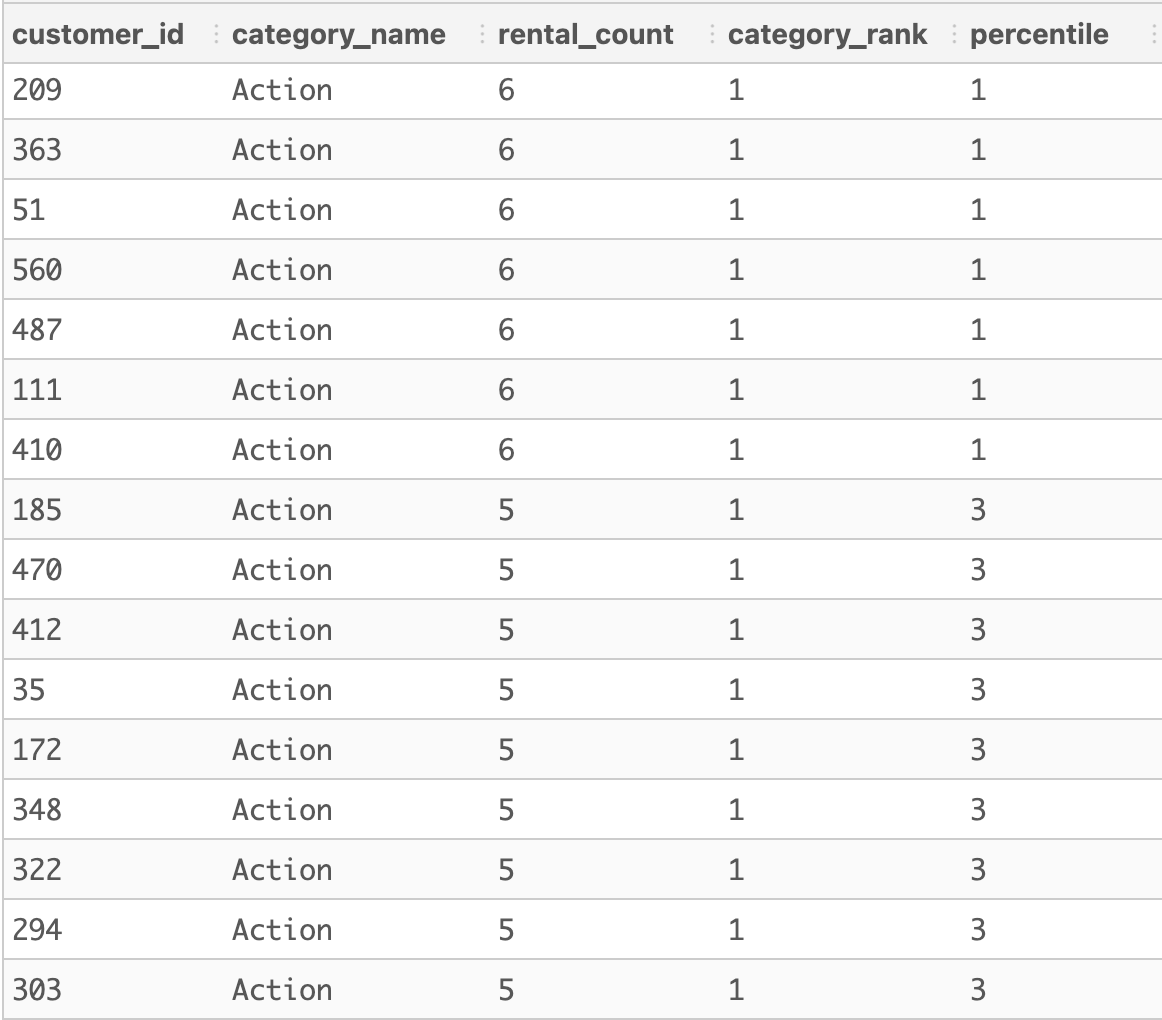

In [92]:
Image(filename="./resources/ma-9.png", width=600)

```sql
-- generate our first top category insights table using all previously generated tables
WITH first_category_insights AS (
    SELECT 
        top_category_percentile.customer_id,
        top_category_percentile.category_name,
        top_category_percentile.rental_count,
        top_category_percentile.rental_count - average_category_count.category_average AS average_comparison,
        top_category_percentile.percentile
   FROM top_category_percentile
   INNER JOIN average_category_count ON top_category_percentile.category_name = average_category_count.category_name
)
```

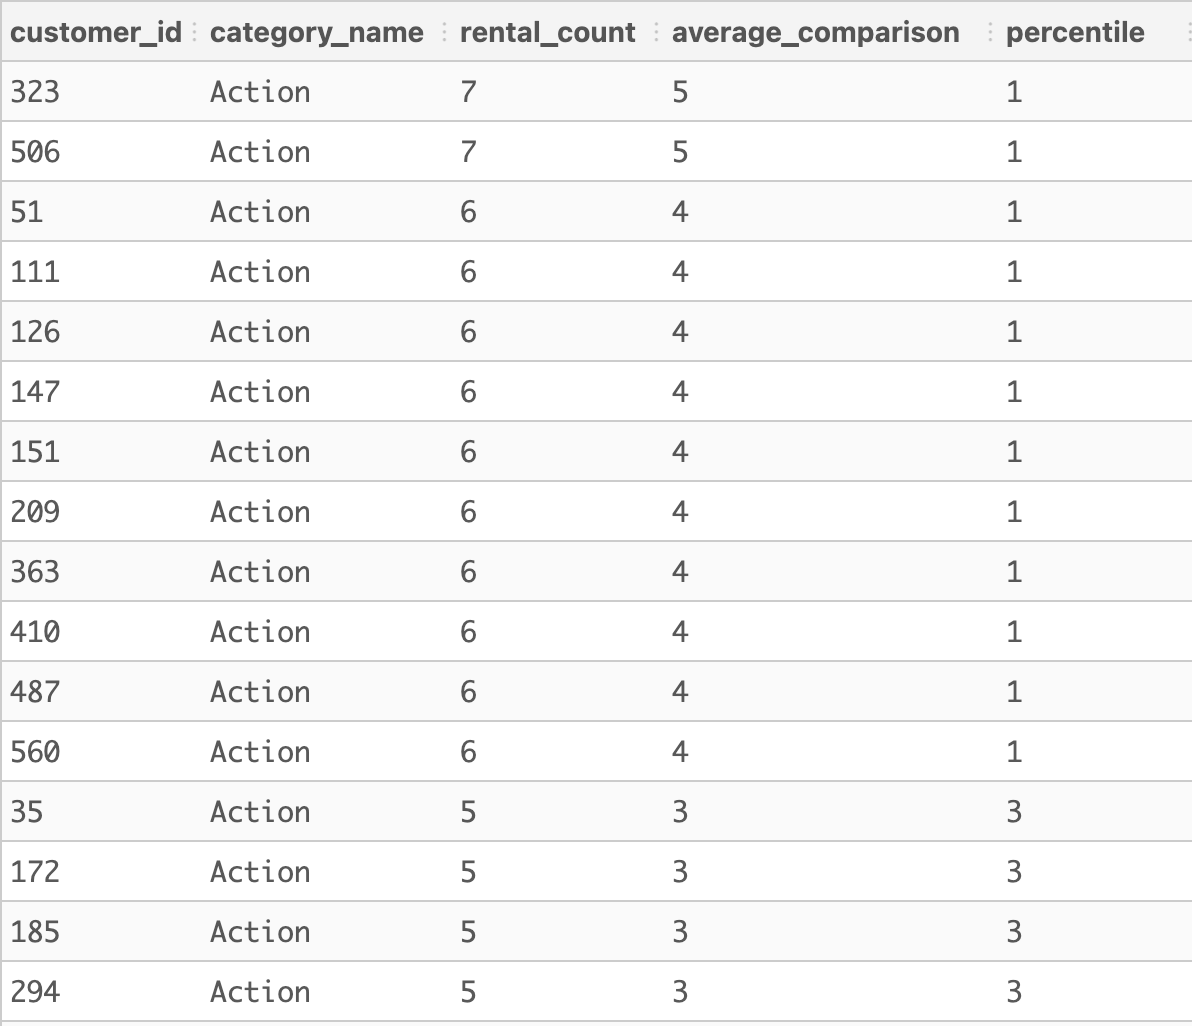

In [93]:
Image(filename="./resources/ma-10.png", width=500)

We have already taken care of 0 value in the percentile column. Out of curiosity, I ran the below query to check if there are customers who have a 0 value in average_comparison column.

```sql
SELECT customer_id
FROM first_category_insights
WHERE average_comparison = 0;
```

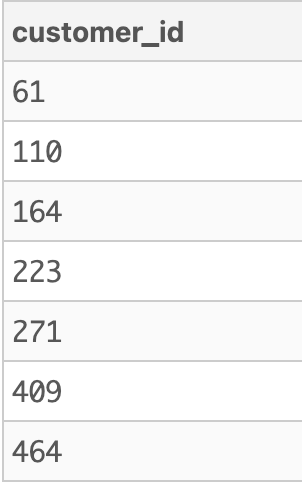

In [94]:
Image(filename="./resources/ma-11.png", width=200)

These 7 customers should be excluded from the marketing campaign as we don't want to tell the customers that they have watched 0 more than the average.

```sql
-- generate the 2nd category insights
WITH second_category_insights AS (
    SELECT 
        top_categories.customer_id,
        top_categories.category_name,
        top_categories.rental_count,
        ROUND(100*top_categories.rental_count::NUMERIC / total_counts.total_count) AS total_percentage
   FROM top_categories
   LEFT JOIN total_counts ON top_categories.customer_id = total_counts.customer_id
   WHERE category_rank = 2
)
```

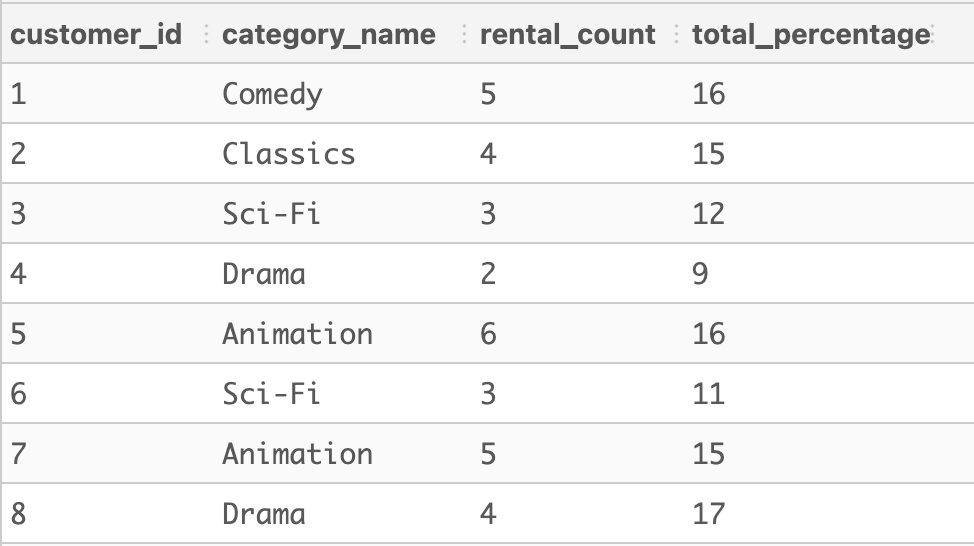

In [95]:
Image(filename="./resources/ma-12.png", width=600)

**CATEGORY RECOMMENDATIONS**
***

Before we recommend movies to customers, let's explore the datasets and test/ verify hypotheses

```sql
-- hypotheses: a film can belong to more than one category
SELECT film_id,
       Count(*) AS num_categories
FROM   dvd_rentals.film_category
GROUP  BY film_id
HAVING Count(*) > 2; 
```

The query returned 0 rows indicating each movie belongs to one and only one category atleast for this dataset

```sql
-- hypotheses : a single actor may show up in multiple movies
-- we will use double aggregation techinque to better understand the relationship b/w actors and films
WITH cte_films_acted AS (
    SELECT
        total_films,
        COUNT(*) num_actors
    FROM (
        SELECT
            actor_id,
            COUNT(*) AS total_films
        FROM dvd_rentals.film_actor
        GROUP BY actor_id 
    ) AS subquery
    GROUP BY total_films 
)
(SELECT * FROM cte_films_acted ORDER BY total_films DESC LIMIT 5)
UNION
(SELECT * FROM cte_films_acted ORDER BY total_films ASC LIMIT 5)
ORDER BY total_films DESC;
```

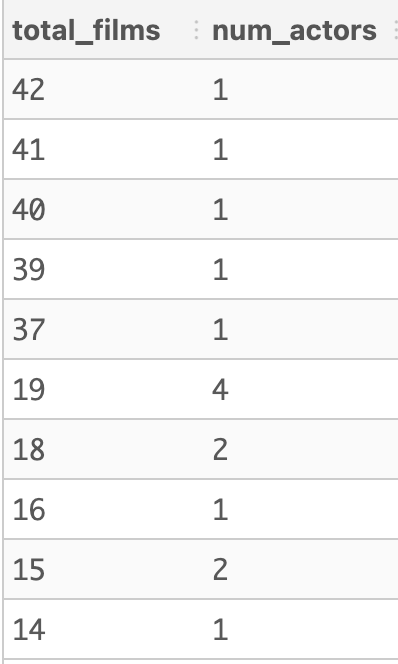

In [96]:
Image(filename='./resources/ma-13.png', width=200)

We see that the least number of films an actor has appeared in is 14 and the most an actor has appeared in is 42.

```sql
-- hypotheses : a film may have multiple actors
-- we will use double aggregation techinque to better understand the relationship b/w actors and films
WITH cte_total_actors AS (
    SELECT
        total_actors,
        COUNT(*) num_films
    FROM (
        SELECT   
            film_id,
            COUNT(*) AS total_actors
        FROM dvd_rentals.film_actor
        GROUP BY film_id 
    ) AS subquery
    GROUP BY total_actors 
)
(SELECT * FROM cte_total_actors ORDER BY total_actors DESC LIMIT 5)
UNION
(SELECT * FROM cte_total_actors ORDER BY total_actors ASC LIMIT 5)
ORDER BY total_actors DESC;
```

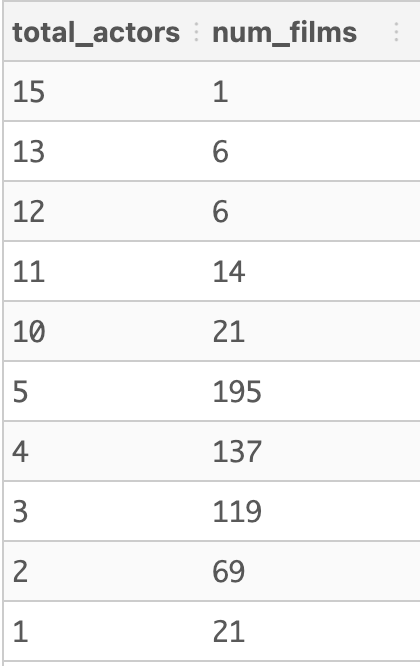

In [97]:
Image(filename='./resources/ma-14.png', width=200)

There are 21 films which have only 1 actor and there is only 1 film which features 15 actors.

# Key Takeaways

1. ```Deciding Which Type of Table Joins to Use```
 - What is the purpose of joining these two tables?
 - How many unique foreign key values exist in each table?
 - What is the distribution of foreign keys within each table? How many records exist per foreign key value in left and right tables?
    - A double aggregation will give more insights
    - The distribution and relationship within the table by the foreign keys is super important because it helps us inspect what our table joining inputs  consist of and also determines what sort of outputs we should expect after joining.
    - 1:1 | 1:many | many:1 | many:many
 - How many overlapping and missing unique foreign key values are there between the two tables?
   - Foreign key values that only exists in left table (anti-join)
   - Foreign key values that only exists in right table (anti-join)
   - Foreign key values that only exists in both tables (left semi join)
- The most important thing when gauging the types of joins you should use is that relationship between the foreign keys and the target tables.

2. ```Dealing With Ties```
 - Sort the values further by an additional condition or criteria
 - you do not want to randomly select single rows as this is not reproducible

3. ```Thinking through customer experience when we make technical decisions that might negatively impact a message or insight```<br>
4. ```Visualize final report, break it sub-reports and work backwards BUT build forwards```
5. ```While being able to write ad-hoc queries to asnwer business queries is good, being able to build/ design a data assets that can answer all the questions is what we should aim for.```